In [68]:
## Packages
import pathlib
import sys

import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

file_path = pathlib.Path('').parent
sys.path.insert(0, file_path)
import local_utils as lu

In [69]:
## Hyperparameters
DATA = 'cifar'
N_CLASSES = 10

N_ROUNDS = 250

DBA = 0
N_MALICIOUS = 1

NEURO = 1
NEURO_P = 0.1

ALPHA = 1
ALPHA_VAL = 10000

In [70]:
## Paths
project_path = (
    pathlib.Path().home() / 
    'Documents' /
    'TAG'
)

experiment_path = (
    project_path / 
    f'{DATA}_{N_CLASSES}' /
    ('neuro' if NEURO else 'classic') /
    'tag' /
    ('distributed' if DBA else 'centralized') /
    f'alpha{ALPHA}--alpha_val{ALPHA_VAL}'
)
experiement_suffix = f'--n_malicious{N_MALICIOUS}'

output_path = experiment_path / 'output'
if not output_path.exists():
    output_path.mkdir(parents=True)
    
subdir_path = (
    experiment_path / 
    f'n_rounds{N_ROUNDS}--d_start1--m_start1--n_malicious{N_MALICIOUS}'
)

In [71]:
## Data
val_path = (
    subdir_path /
    'data' /
    (
        'output_val_ks'
        + (f'--neuro_p{NEURO_P}' if NEURO else '')
        + '.npy'
    )
)
val_ks = np.load(val_path, allow_pickle=True)

user_path = (
    subdir_path /
    'data' /
    (
        'output_user_ks'
        + (f'--neuro_p{NEURO_P}' if NEURO else '')
        + '.npy'
    )
)
user_ks = np.load(user_path, allow_pickle=True)

id_path = (
        subdir_path /
        'data' /
        (
                'output_user'
                + (f'--neuro_p{NEURO_P}' if NEURO else '')
                + '.npy'
        )
)
user_id = np.load(id_path, allow_pickle=True)

data_path = (
        subdir_path /
        'data' /
        (
                'output_data'
                + (f'--neuro_p{NEURO_P}' if NEURO else '')
                + '.npy'
        )
)
class_data = np.load(data_path, allow_pickle=True)
class_data = pd.DataFrame(class_data)

columns = ['id', 'malicious'] + [str(i) for i in range(class_data.shape[1] - 2)]
class_data.columns = columns

print(class_data.iloc[:5, :5])

    id  malicious         0         1         2
0  0.0        1.0  0.379798  0.058586  0.014141
1  1.0        0.0  0.195960  0.200000  0.040404
2  2.0        0.0  0.105263  0.024291  0.295547
3  3.0        0.0  0.060606  0.078788  0.105051
4  4.0        0.0  0.016162  0.092929  0.006061


In [72]:
## Manipulation

## Validation
# remove last validation check for terminated iteration
val_data = val_ks[:-1]

# set aside scaling header
# remove useless round information
val_data, scaling_header = val_data[1:], val_data[0, 1:]

# separate round info from class distances
# scale class distances
val_data_round, val_data_values = val_data[:, 0], val_data[:, 1:]
val_data_values *= scaling_header

# compute the defense threshold
# ensure that the threshold is not greater than 1
val_data_max = val_data_values.max(axis=1)
val_data_thresh = lu.min_mean_smooth(val_data_max, scale=2)
val_data_thresh = np.minimum(val_data_thresh, 1)

## Users
# determine if user should update the global model
user_malicious, user_round, user_values = (
    user_ks[:, 0], user_ks[:, 1], user_ks[:, 2:]
)
user_values_max = user_values.max(axis=1)
user_update = np.array([
    value <= val_data_thresh[int(r - 1)]
    for r, value in zip(user_round, user_values_max)
])

# combine user data as a dataframe
# ensure that user data is the same, combine user id
user_data = pd.DataFrame({
    'malicious': user_malicious,
    'round': user_round,
    'update': user_update,
})

assert np.equal(user_data['malicious'].values, user_id[:, 0]).all()
assert np.equal(user_data['round'].values, user_id[:, 1]).all()
user_data['id'] = user_id[:, 2]

print(user_data.head())

   malicious  round  update    id
0        1.0    1.0    True   0.0
1        0.0    1.0    True  47.0
2        0.0    1.0    True   9.0
3        0.0    1.0    True  32.0
4        0.0    1.0    True  85.0


C:\Users\joela\AppData\Local\Temp\ipykernel_27056\1478531661.py:9: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  heat_data = heat_data.replace({False: 0, True: 1})


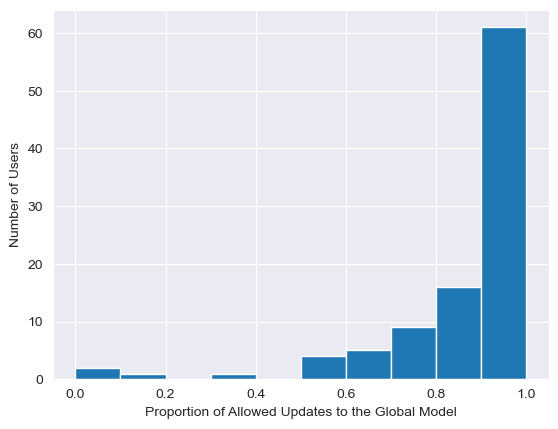

id
27.0    0.00000
0.0     0.00800
43.0    0.10000
91.0    0.37931
40.0    0.50000
         ...   
53.0    1.00000
54.0    1.00000
57.0    1.00000
73.0    1.00000
98.0    1.00000
Length: 99, dtype: float64


<Axes: xlabel='round', ylabel='id'>

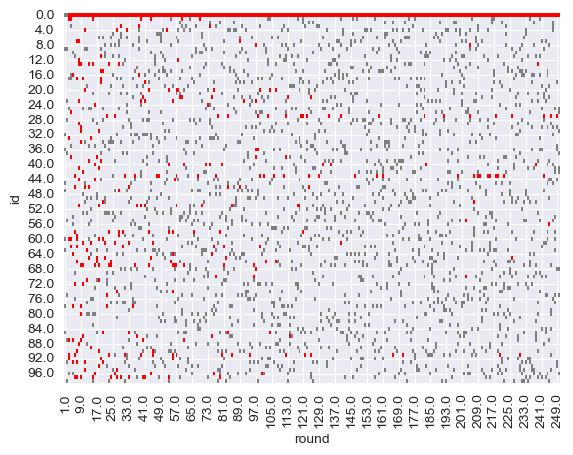

In [73]:
## Heatmap 
heat_data = user_data.pivot(
    index='id',
    columns='round',
    values='update'
)

cmap = sns.color_palette(['red', 'blue', 'grey'])
heat_data = heat_data.replace({False: 0, True: 1})

numerator = heat_data.sum(axis=1)
denominator = heat_data.notna().sum(axis=1)
ratio = numerator / denominator

ratio.hist()
plt.ylabel('Number of Users')
plt.xlabel('Proportion of Allowed Updates to the Global Model')
plt.show()

ratio = ratio.sort_values()
print(ratio)

sns.heatmap(heat_data, cmap=cmap, cbar=False)

In [74]:
list(ratio.loc[ratio < .20].index)

[27.0, 0.0, 43.0]

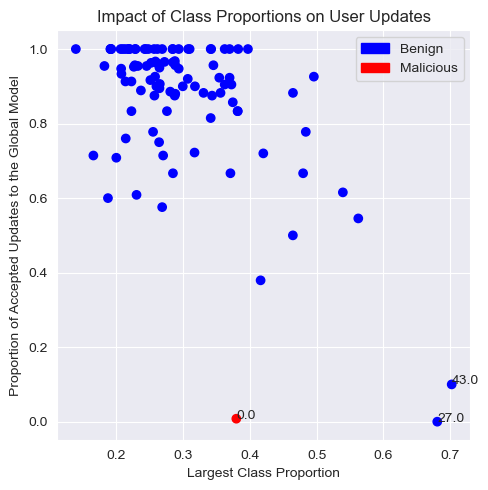

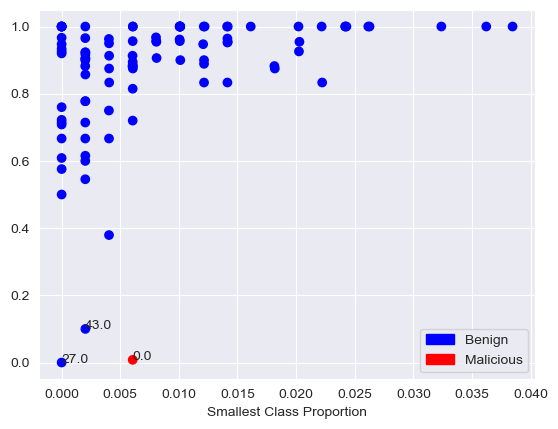

In [79]:
## Class Proportions
heat_data = class_data.set_index('id')
heat_data = heat_data.drop(columns=['malicious'])

heat_data_max = heat_data.max(axis=1)
heat_data_max.name = 'max'
heat_data_min = heat_data.min(axis=1)
heat_data_min.name = 'min'
ratio.name = 'ratio'

merged = pd.merge(heat_data_max, heat_data_min, on='id')
merged = pd.merge(merged, ratio, on='id')

merged['color'] = 0
merged.loc[0, 'color'] = 1

cmap = sns.color_palette(['blue', 'red'])
colors = merged['color'].map({0: cmap[0], 1: cmap[1]})

plt.figure(figsize=(5, 5))
plt.title('Impact of Class Proportions on User Updates')

plt.scatter(merged['max'], merged['ratio'], c=colors)
for i, row in merged.iterrows():
    if row['ratio'] < .20:
        plt.text(row['max'], row['ratio'], row.name)

plt.ylabel('Proportion of Accepted Updates to the Global Model')
plt.xlabel('Largest Class Proportion')

plt.legend(
    handles=[
        mpl.patches.Patch(color=cmap[0], label='Benign'),
        mpl.patches.Patch(color=cmap[1], label='Malicious'),
    ],
)

out_path = pathlib.Path('extra')
plt.tight_layout()
plt.savefig(out_path / 'ratio.png')

plt.figure()
plt.scatter(merged['min'], merged['ratio'], c=colors)
for i, row in merged.iterrows():
    if row['ratio'] < .20:
        plt.text(row['min'], row['ratio'], row.name)
    
plt.xlabel('Smallest Class Proportion')

plt.legend(
    handles=[
        mpl.patches.Patch(color=cmap[0], label='Benign'),
        mpl.patches.Patch(color=cmap[1], label='Malicious'),
    ],
)

